In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math

# Data loading

In [2]:
train_set = pd.read_csv('mnist_train.csv',header=None)
train_set = np.array(train_set)
train_set_data = train_set[:,1:]
train_set_label = train_set[:,0]
test_set = pd.read_csv('mnist_test.csv',header=None)
test_set = np.array(test_set)
test_set_data = test_set[:,1:]
test_set_label = test_set[:,0]

In [3]:
train_set_data_normalized = train_set_data/255.0
test_set_data_normalized = test_set_data/255.0 

# RBM Implementation

In [4]:
class RBM:
    def __init__(self,input_layer_size,hidden_layer_size):
        self.input_layer_array = np.zeros(input_layer_size)
        self.hidden_layer_array = np.zeros(hidden_layer_size)
        self.weight_matrix_array = np.random.rand(input_layer_size, hidden_layer_size)/np.sqrt(input_layer_size)
        self.input_bias_array = np.random.rand(input_layer_size, 1)/np.sqrt(input_layer_size)
        self.hidden_bias_array = np.random.rand(hidden_layer_size, 1)/np.sqrt(input_layer_size)
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward_pass(self, v_layer_array):
        v_layer_array_temp = v_layer_array.copy()
        h_layer_array_temp = np.matmul(np.transpose(self.weight_matrix_array), v_layer_array_temp) \
                            + self.hidden_bias_array
        h_layer_array = self.sigmoid(h_layer_array_temp)
        del h_layer_array_temp
        del v_layer_array_temp
        return h_layer_array
    
    def backward_pass(self, h_layer_array):
        h_layer_array_temp = h_layer_array.copy()
        v_layer_array_temp = np.matmul(self.weight_matrix_array, h_layer_array_temp) \
                            + self.input_bias_array
        v_layer_array = self.sigmoid(v_layer_array_temp)
        del h_layer_array_temp
        del v_layer_array_temp
        return v_layer_array
    
    def sample(self, p_a_given_b_dist):
        dim = p_a_given_b_dist.shape[0]
        true_idx = np.random.uniform(0, 1, dim).reshape(dim, 1) <= p_a_given_b_dist
        sampled = np.zeros((dim, 1))
        sampled[true_idx] = 1  
        return sampled
    
    def Gibbs_sampling(self, v_0, k=1):  # v_0 is training example array, k is number of steps to run gibbs chain
        
        v_k = v_0.copy()
        
        prob_h_given_v = self.forward_pass(v_k)
        h_0 = self.sample(prob_h_given_v)

        prob_v_given_h = self.backward_pass(h_0)
        v_k = self.sample(prob_v_given_h)  
        
        if k==1:
            h_k = h_0.copy()
            
        for i in range(k-1):
            prob_h_given_v = self.forward_pass(v_k)
            h_k = self.sample(prob_h_given_v)
            
            prob_v_given_h = self.backward_pass(h_k)
            v_k = self.sample(prob_v_given_h)  

        return h_0, v_k, h_k

    def contrastive_divergence_train(self, data_, epochs=1, k=1, lr = 0.1, lamda=0, m=0, batch_size=500): 
        # k is number of steps to run gibbs chain
        # lamda is weight decay, m is momentum term constant
        weight_delta_t_minus_1 = np.zeros_like(self.weight_matrix_array)
        input_bias_delta_t_minus_1 = np.zeros_like(self.input_bias_array)
        hidden_bias_delta_t_minus_1 = np.zeros_like(self.hidden_bias_array)
        data = data_.copy()
        if batch_size>data.shape[0]:
            batch_size = data.shape[0]
        for i in range(epochs):
            np.random.shuffle(data)
            error = 0
            for z in range(data.shape[0]//batch_size):
                weight_matrix_array_delta = np.zeros_like(self.weight_matrix_array)
                input_bias_array_delta = np.zeros_like(self.input_bias_array)
                hidden_bias_array_delta = np.zeros_like(self.hidden_bias_array)
                for j in range(z*batch_size,(z+1)*batch_size):
                    
                    v_0 = data[j].copy()
                    v_0 = v_0.reshape(-1,1)
                    
                    h_0, v_k, h_k = self.Gibbs_sampling(v_0, k)                
                    weight_matrix_array_delta += np.matmul(v_0, np.transpose(h_0)) - np.matmul(v_k, np.transpose(h_k))
                    input_bias_array_delta += v_0 - v_k
                    hidden_bias_array_delta += h_0 - h_k
                    error += np.sum((v_0 - v_k)**2)
                    
                weight_delta_t = lr*weight_matrix_array_delta - lamda*self.weight_matrix_array \
                                + m*weight_delta_t_minus_1
                self.weight_matrix_array += weight_delta_t
                
                input_bias_delta_t = lr*input_bias_array_delta + m*input_bias_delta_t_minus_1
                self.input_bias_array += input_bias_delta_t
                
                hidden_bias_delta_t = lr*hidden_bias_array_delta + m*hidden_bias_delta_t_minus_1
                self.hidden_bias_array += hidden_bias_delta_t
                
                weight_delta_t_minus_1 = weight_delta_t
                input_bias_delta_t_minus_1 = input_bias_delta_t
                hidden_bias_delta_t_minus_1 = hidden_bias_delta_t
                
            print('Epoch:', i,' Error:',error/((data.shape[0]//batch_size)*batch_size))
            

In [5]:
def visualize(data_list):
    if len(data_list) == 1:
        image = data_list[0].copy()
        data = image.reshape(28,28)
        plt.imshow(data)
    else:
        data = np.zeros((28,28*len(data_list)))
        for i in range(len(data_list)):
            data[:,28*i:28*(i+1)] = data_list[i].reshape(28,28)
        plt.imshow(data)

In [75]:
np.random.seed(0)
rbm = RBM(28 * 28, 100)
print("Start RBM training.")
rbm.contrastive_divergence_train(train_set_data_normalized[:60000], epochs=10, k=20, lr=0.1, lamda=0.0, m=0.1, batch_size=1)
print("Finish RBM training.")

Start RBM training.
Epoch: 0  Error: 75.24941685684894
Epoch: 1  Error: 69.84315698756852
Epoch: 2  Error: 67.8420468568503
Epoch: 3  Error: 66.88626182417103
Epoch: 4  Error: 66.4591931967199
Epoch: 5  Error: 66.20175999410426
Epoch: 6  Error: 66.01049842547758
Epoch: 7  Error: 65.95215430783041
Epoch: 8  Error: 65.89825620325509
Epoch: 9  Error: 65.84268966730669
Finish RBM training.


# Saving model weights

In [76]:
weight_file = open(b"model/weight_matrix.npy","wb")
input_bias_file = open(b"model/input_bias_array.npy","wb")
hidden_bias_file = open(b"model/hidden_bias_array.npy","wb")

pickle.dump(rbm.weight_matrix_array,weight_file)
pickle.dump(rbm.input_bias_array,input_bias_file)
pickle.dump(rbm.hidden_bias_array,hidden_bias_file)

# Testing using saved model

In [6]:
rbm_trained = RBM(28 * 28, 100)

weight_file = open(b"model/weight_matrix.npy","rb")
input_bias_file = open(b"model/input_bias_array.npy","rb")
hidden_bias_file = open(b"model/hidden_bias_array.npy","rb")

rbm_trained.weight_matrix_array = pickle.load(weight_file)
rbm_trained.input_bias_array = pickle.load(input_bias_file)
rbm_trained.hidden_bias_array = pickle.load(hidden_bias_file)

# Visualizing

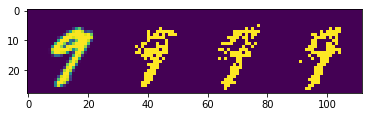

In [7]:
v_0 = test_set_data_normalized[20].copy()


v_0 = v_0.reshape(-1,1)
prob_h_given_v = rbm_trained.forward_pass(v_0)
h_0 = rbm_trained.sample(prob_h_given_v)
prob_v_given_h = rbm_trained.backward_pass(h_0)
v_1 = rbm_trained.sample(prob_v_given_h) 
a_1 = prob_v_given_h.copy()

prob_h_given_v = rbm_trained.forward_pass(v_1)
h_1 = rbm_trained.sample(prob_h_given_v)
prob_v_given_h = rbm_trained.backward_pass(h_1)
v_2 = rbm_trained.sample(prob_v_given_h)
a_2 = prob_v_given_h.copy()

prob_h_given_v = rbm_trained.forward_pass(v_2)
h_2 = rbm_trained.sample(prob_h_given_v)
prob_v_given_h = rbm_trained.backward_pass(h_2)
v_3 = rbm_trained.sample(prob_v_given_h)
a_3 = prob_v_given_h.copy()

visualize([v_0,v_1,v_2,v_3])
# visualize([v_0,a_1,a_2,a_3])

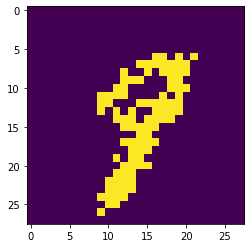

In [9]:
v_0 = test_set_data_normalized[20].copy()
v_0 = v_0.reshape(-1,1)
h_0, v_k, h_k = rbm_trained.Gibbs_sampling(v_0, k=10)
visualize([v_k])

# Code to convert mnist dataset to csv

reference https://pjreddie.com/projects/mnist-in-csv/

def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

convert("train-images-idx3-ubyte", "train-labels-idx1-ubyte",
        "mnist_train.csv", 60000)
convert("t10k-images-idx3-ubyte", "t10k-labels-idx1-ubyte",
        "mnist_test.csv", 10000)